# Breast Cancer Analysis 
---

Implemented KNN and Random Forest Classifier from scratch, demonstrated heatmap and other graphical plots for undertanding of the dataset.

In [1]:
import numpy as np
import pandas as pd
import csv
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
def LoadData(features):
    df = pd.read_csv('breast-cancer-wisconsin.csv', names= features)
    return df

In [3]:
def remove_column(df, column_name):
    
    X = df.drop(column_name, axis=1)
    removed_column = df[column_name]
    return X, removed_column

In [4]:
def remove_symbol(df):
    
    str_cols = df.select_dtypes([np.object]).columns
    df[str_cols] = df[str_cols].replace("?",np.NaN)
    df = df.dropna(axis=0,how='any')
    
    return df

In [5]:
def scaler(df, features):
    
    sc = StandardScaler()
    df = sc.fit_transform(df)
    
    return df

In [6]:
def split_Data(X, y):
    
    X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.2, stratify = y)
    return X_Train, X_Test, y_Train, y_Test

In [7]:
def graph_representations(df, X_PCA, y, features):
    
    #PCA1 and PCA2 scatter plot
    plt.figure(figsize=(8,6))
    plt.title("Principal Component Analysis Graphical Representation",fontsize=20)
    plt.scatter(X_PCA['PCA1'],X_PCA['PCA2'],c=y) 
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.show()
    print ("      Violet: Benign, Yellow: Malignant")
    print ("")
    #heatmap for all the features except Student_ID and the label/Classes column
    heat = sns.heatmap(df[features].corr(), vmax=1, square=True, annot=False)
    print (heat)

In [8]:
def PCA_Analysis(X_new):
    
    pca = PCA(n_components = 4)
    X_PCA = pca.fit_transform(X_new)
    X_PCA = pd.DataFrame(X_PCA, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])

    return X_PCA

# KNN Implementation

In [9]:
def model_KNN(X_Train, X_Test, y_Train, y_Test):
    
    classifier = KNN(4, X_Train, X_Test, y_Train, y_Test)
    cv=5
    Cross_Validation(classifier, X_Train, y_Train, cv)
    K1 = 1
    K2 = 26
    Grid_Search_CV(K1, K2, X_Train, y_Train, cv)

In [10]:
def KNN(K, X_Train, X_Test, y_Train, y_Test):
    
    classifier = KNeighborsClassifier(n_neighbors = K, metric = 'euclidean')

    classifier.fit(X_Train, y_Train)
    y_predicted = classifier.predict(X_Test)

    print ('Accuracy obtained with KNN: {0} %'.format(accuracy_score(y_Test,y_predicted) * 100))

    return classifier

In [11]:
def Cross_Validation(classifier, X_Train, y_Train, cv):
    
    cv_scores = cross_val_score(classifier, X_Train, y_Train, cv=5)
    print ('Accuracy obtained after cross validation: {0} %'.format(np.mean(cv_scores) * 100))

In [12]:
def Grid_Search_CV(K1, K2, X_Train, y_Train, cv):
    
    classifier_2 = KNeighborsClassifier()
    param_grid = {"n_neighbors": np.arange(K1, K2)}
    knn_gscv = GridSearchCV(classifier_2, param_grid, cv=5)
    knn_gscv.fit(X_Train, y_Train)
    print ("Optimized K: ",knn_gscv.best_params_)
    print ("Accuracy obtained after GridSearchCV: {0} %".format(knn_gscv.best_score_ * 100))

# Random Forest Implementation

In [13]:
def check_purity(dataset):
    
    label_column = dataset[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [14]:
def classify_data(dataset):
    
    label_column = dataset[:, -1]
    unique_classes, count_unique_classes = np.unique(label_column, return_counts=True)

    index = count_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [15]:
def get_potential_splits(dataset, random_subspace):
    
    potential_splits = {}
    _, n_of_columns = dataset.shape
    column_indices = list (range(n_of_columns -1))
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
        
    for column_index in column_indices:
        values = dataset[:,column_index]
        unique_values = np.unique(values)
        potential_splits[column_index] = unique_values
        
    return potential_splits

In [16]:
def calculate_entropy(dataset):
    
    label_column = dataset[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [17]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [18]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data_rf(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [19]:
def split_data_rf(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
     
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [20]:
def predicting_example(example, tree):
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]
            
    if not isinstance(answer, dict):
        return answer
    else:
        residual_tree = answer
        return predicting_example(example, residual_tree)

In [21]:
def decision_tree_predictions(X_RF_Test, tree):
    
    predictions = X_RF_Test.apply(predicting_example, args=(tree,), axis=1)
    
    return predictions

In [22]:
def bootstrapping(X_RF, n_bootstrap):
    
    bootstrap_indices = np.random.randint(low = 0, high = len(X_RF), size = n_bootstrap)#indexing the X_RF and then randomly selecting n indices.
    bootstrapped_X_RF = X_RF.iloc[bootstrap_indices] #storing the rows for the above randomly selected indices in a dataframe.

    return bootstrapped_X_RF

In [23]:
def determine_feature_type(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [24]:
def decision_tree_algorithm(df, max_depth, random_subspace, min_samples=2, counter=0):
    
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_feature_type(df)
        data = df.values
    else:
        data = df           
    
 
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth): #checking if data is pure or not
        classification = classify_data(data)
        
        return classification

    else:    
        counter += 1

        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data_rf(data, split_column, split_value)
        
        # checking for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determining the question for decision tree
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
       
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiating a sub-tree
        sub_tree = {question: []}
    
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [25]:
def random_forest_algorithm(X_RF, n_trees, n_bootstrap, n_features, dt_max_depth):
    
    forest = []
    for i in range(n_trees):
        X_RF_bootstrapped = bootstrapping(X_RF, n_bootstrap)
        tree = decision_tree_algorithm(X_RF_bootstrapped, dt_max_depth, n_features)
        forest.append(tree)
    
    return forest

In [26]:
def random_forest_predictions(X_RF_Test, forest):
    
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(X_RF_Test, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]

    return random_forest_predictions

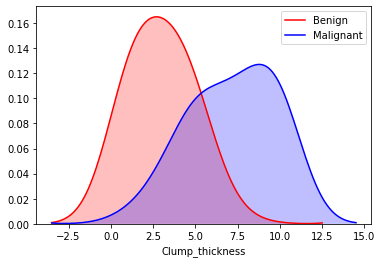

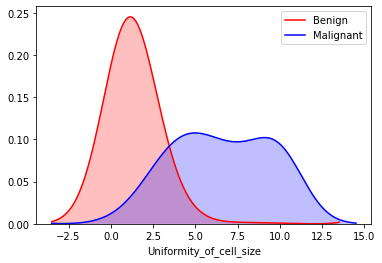

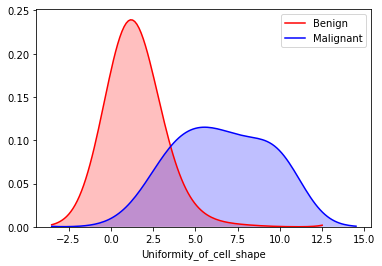

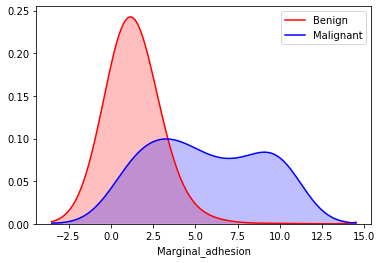

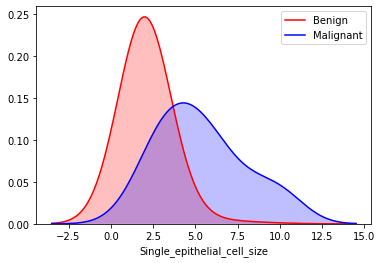

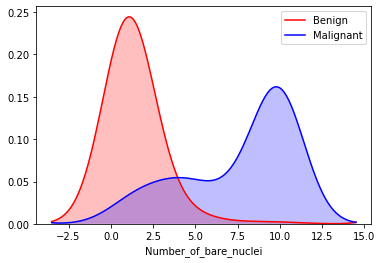

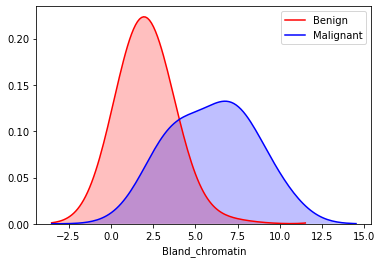

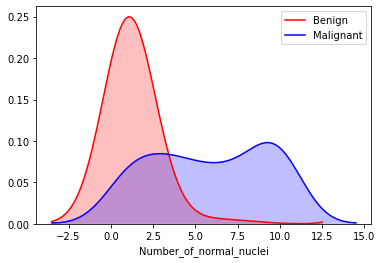

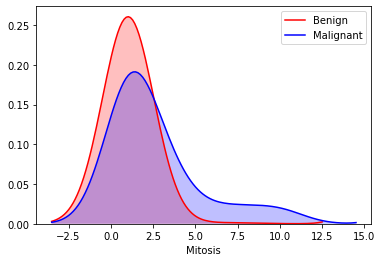

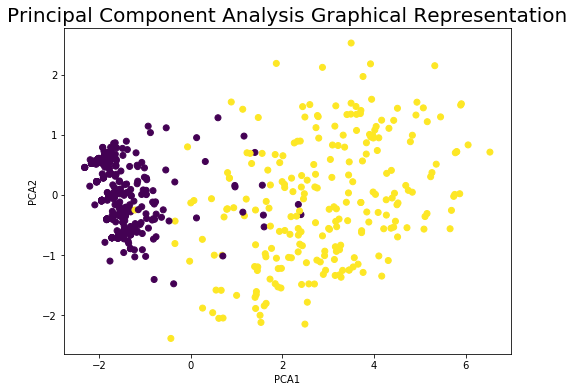

      Violet: Benign, Yellow: Malignant

AxesSubplot(0.241667,0.125;0.503333x0.755)
Accuracy obtained with KNN: 95.62043795620438 %
Accuracy obtained after cross validation: 97.25104253544622 %
Optimized K:  {'n_neighbors': 3}
Accuracy obtained after GridSearchCV: 97.80150125104254 %
Accuracy with Random Forest = 95.62043795620438%


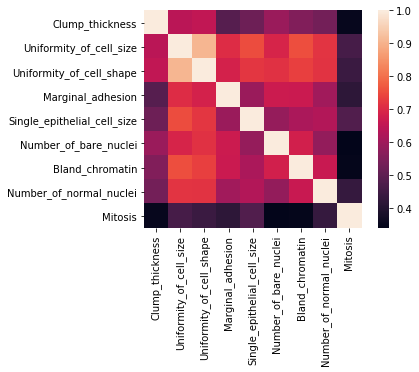

In [27]:
def main():
    
    #feature specification
    features = ['Sample_ID','Clump_thickness','Uniformity_of_cell_size','Uniformity_of_cell_shape','Marginal_adhesion','Single_epithelial_cell_size','Number_of_bare_nuclei','Bland_chromatin','Number_of_normal_nuclei','Mitosis','Classes']
    #Loading dataset to a dataframe by calling a funtion LoadData
    df = LoadData(features)
    
    #removed the rows containing "?" symbol
    df = remove_symbol(df)
    #invalid parsing is set to NaN using coerce
    df = df.apply(pd.to_numeric, errors='coerce', downcast = 'integer') 
    #dropping "Sample ID" column from the dataframe
    X, SID = remove_column(df, "Sample_ID") 
    
    #Feature Plots
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
        if(col!='Sample_ID' and col!='Classes'):
            sns.kdeplot(df.loc[(df['Classes']== 2),col], color='r', shade=True, Label='Benign', bw=1.5) 
            sns.kdeplot(df.loc[(df['Classes']== 4),col], color='b', shade=True, Label='Malignant', bw=1.5) 
            plt.xlabel(col) 
            plt.show()
            
    #creating a copy of the dataset for Random Forest Algorithm
    RF_Data = X
    X_G=X
    #removed "Sample Id" from the feature list
    ft_SID = features.pop(0)  
    #removed "Classes" from the feature list
    ft_Classes = features.pop(9)
    #dropped "Classes" column from the X dataframe
    X, y = remove_column(X, "Classes") 
    
    #Feature Scaling
    X_scaled = scaler(X, features)
    normalised_X = pd.DataFrame(X_scaled, columns = features)
    
    #Implementing SelectKbest features using Scikit
    X_new =  SelectKBest(f_regression, k=8).fit_transform(normalised_X,y)
    X_new = pd.DataFrame(X_new, columns = ['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8'])
    
    #Implementing Principal Component Analysis
    X_PCA = PCA_Analysis(X_new)
    #function call to display PCA1, PCA2 and Heatmap graphs
    graph_representations(normalised_X, X_PCA, y, features)
    
    #splitting up the train and test data for KNN Algorithm
    X_Train, X_Test, y_Train, y_Test = split_Data(X_PCA, y)
    
    #function call to implement KNN algorithm
    model_KNN(X_Train, X_Test, y_Train, y_Test)

    
    #function call to split train and test data for Random Forest Algorithm
    X_RF, X_RF_Test, y_RF, y_RF_Test = split_Data(RF_Data, y)
    #specifying the number of decision trees to be built
    n_of_trees = 4
    #specifying the bootstrap size
    intended_bootstrap_size = (int) (len(X_RF)/n_of_trees)
    #function call to implement Random Forest Algorithm
    forest = random_forest_algorithm(X_RF, n_trees= n_of_trees, n_bootstrap = intended_bootstrap_size, n_features=3, dt_max_depth=4)
    predictions = random_forest_predictions(X_RF_Test, forest)
    accuracy = accuracy_score(y_RF_Test, predictions)

    print("Accuracy with Random Forest = {}%".format(accuracy*100))

main()